In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import cv2
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import Adadelta,AdamW
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
%matplotlib inline

# Load Image

In [2]:
image_path="/kaggle/input/wonders-of-the-world-image-classification/Wonders of World/Wonders of World/"

# Compare Each Class Length

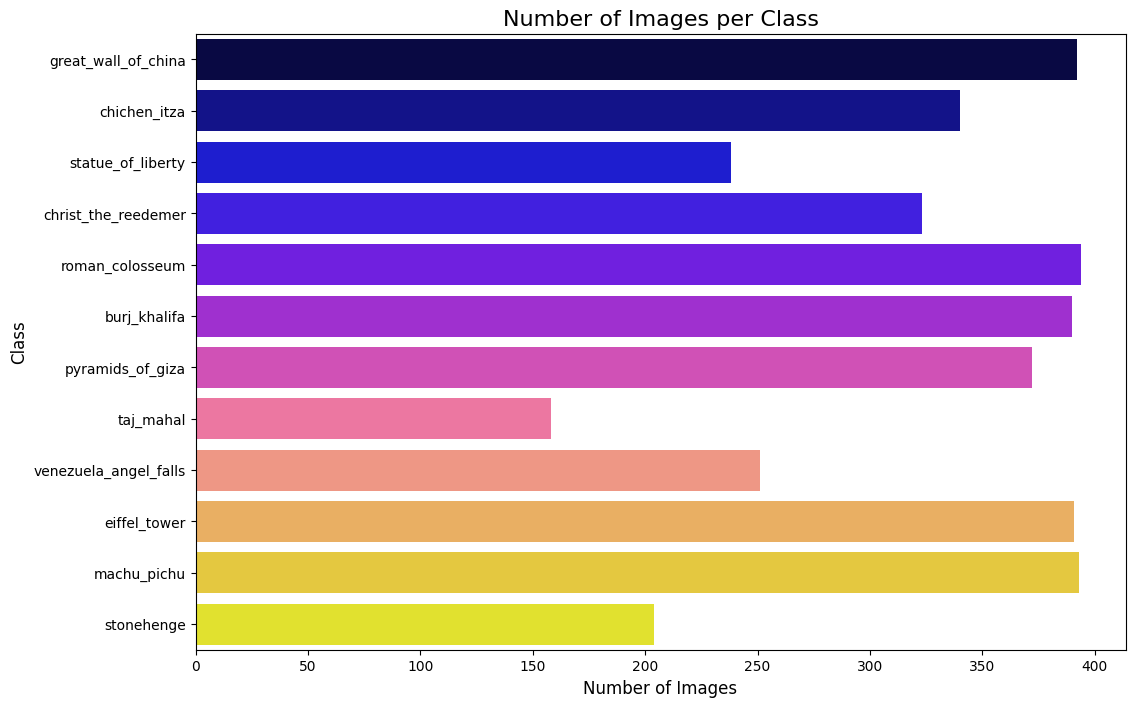

In [3]:
# Get the list of all subdirectories (classes)
classes = os.listdir(image_path)

# Initialize an empty list to store labels
labels = []

# Loop through each class and get the number of images in each class
for class_name in classes:
    class_dir = os.path.join(image_path, class_name)
    if os.path.isdir(class_dir):  # Ensure it's a directory
        num_images = len(os.listdir(class_dir))  # Count number of images in each class
        labels.extend([class_name] * num_images)  # Append the class label for each image

# Count the number of images per class
label_counts = Counter(labels)

# Convert the label counts into a DataFrame for seaborn
import pandas as pd
label_counts_df = pd.DataFrame(list(label_counts.items()), columns=['Class', 'Count'])

# Create the seaborn barplot
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Class', data=label_counts_df, palette='gnuplot2')

# Add title and labels
plt.title('Number of Images per Class', fontsize=16)
plt.xlabel('Number of Images', fontsize=12)
plt.ylabel('Class', fontsize=12)

# Show the plot
plt.show()

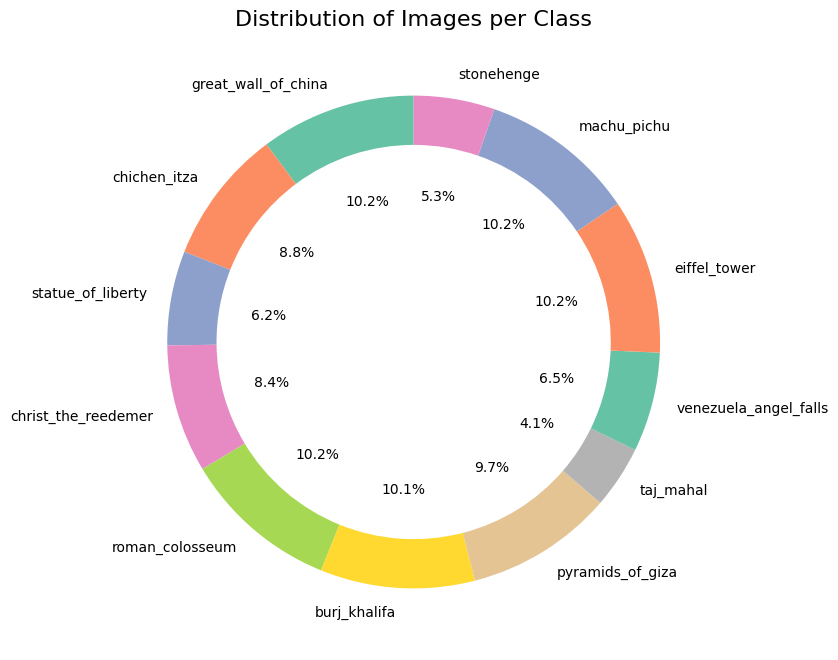

In [4]:
# Convert the label counts into a DataFrame for better visualization
label_counts_df = pd.DataFrame(list(label_counts.items()), columns=['Class', 'Count'])

# Create the donut chart
plt.figure(figsize=(10, 8))
plt.pie(label_counts_df['Count'], labels=label_counts_df['Class'], autopct='%1.1f%%', startangle=90, wedgeprops={'width': 0.2}, colors=sns.color_palette("Set2", len(label_counts_df)))

# Add a title
plt.title('Distribution of Images per Class', fontsize=16)
plt.axis("off")
# Show the plot
plt.show()

In [5]:
classes=os.listdir(image_path)
images=[]
labels=[]

for class_name in tqdm(classes,desc="Processing Classes"):
    class_dir=os.path.join(image_path,class_name)
    if os.path.isdir(class_dir):
        for img_name in tqdm(os.listdir(class_dir),desc=f"Processing images in {class_name}", leave=False):
            img_path=os.path.join(class_dir,img_name)

            if img_path.endswith(".jpg") or img_path.endswith(".png"):
                img=image.load_img(img_path,target_size=(128,128))
                img_array=image.img_to_array(img)
                images.append(img_array)
                labels.append(class_name)


X=np.array(images)
y=np.array(labels)

Processing Classes: 100%|██████████| 12/12 [00:22<00:00,  1.84s/it]                


In [6]:
print(f"Images : {X[: 5]}")
print("#"*150)
print(f"Label : {y[: 5]}")

Images : [[[[255. 255. 255.]
   [254. 254. 254.]
   [254. 254. 254.]
   ...
   [254. 254. 254.]
   [254. 254. 254.]
   [254. 254. 254.]]

  [[255. 255. 255.]
   [254. 254. 254.]
   [254. 254. 254.]
   ...
   [254. 254. 254.]
   [254. 254. 254.]
   [254. 254. 254.]]

  [[255. 255. 255.]
   [254. 254. 254.]
   [254. 254. 254.]
   ...
   [254. 254. 254.]
   [254. 254. 254.]
   [254. 254. 254.]]

  ...

  [[  6.   6.   6.]
   [  9.   9.   9.]
   [ 11.  11.  11.]
   ...
   [  8.   9.   4.]
   [ 21.  21.  21.]
   [  4.   4.   4.]]

  [[ 10.  10.  10.]
   [  7.   7.   7.]
   [  7.   7.   7.]
   ...
   [  2.   3.   0.]
   [ 39.  39.  39.]
   [ 15.  15.  15.]]

  [[  9.   9.   9.]
   [  7.   7.   7.]
   [  9.   9.   9.]
   ...
   [ 31.  30.  26.]
   [ 12.  12.  12.]
   [ 28.  28.  28.]]]


 [[[  0. 116. 186.]
   [  0. 116. 186.]
   [  0. 117. 187.]
   ...
   [163. 178. 197.]
   [174. 187. 203.]
   [170. 186. 212.]]

  [[  1. 118. 187.]
   [  1. 118. 187.]
   [  2. 119. 188.]
   ...
   [207. 218

In [7]:
label_name=np.unique(y)
print(f"Label Name : {label_name}")

Label Name : ['burj_khalifa' 'chichen_itza' 'christ_the_reedemer' 'eiffel_tower'
 'great_wall_of_china' 'machu_pichu' 'pyramids_of_giza' 'roman_colosseum'
 'statue_of_liberty' 'stonehenge' 'taj_mahal' 'venezuela_angel_falls']


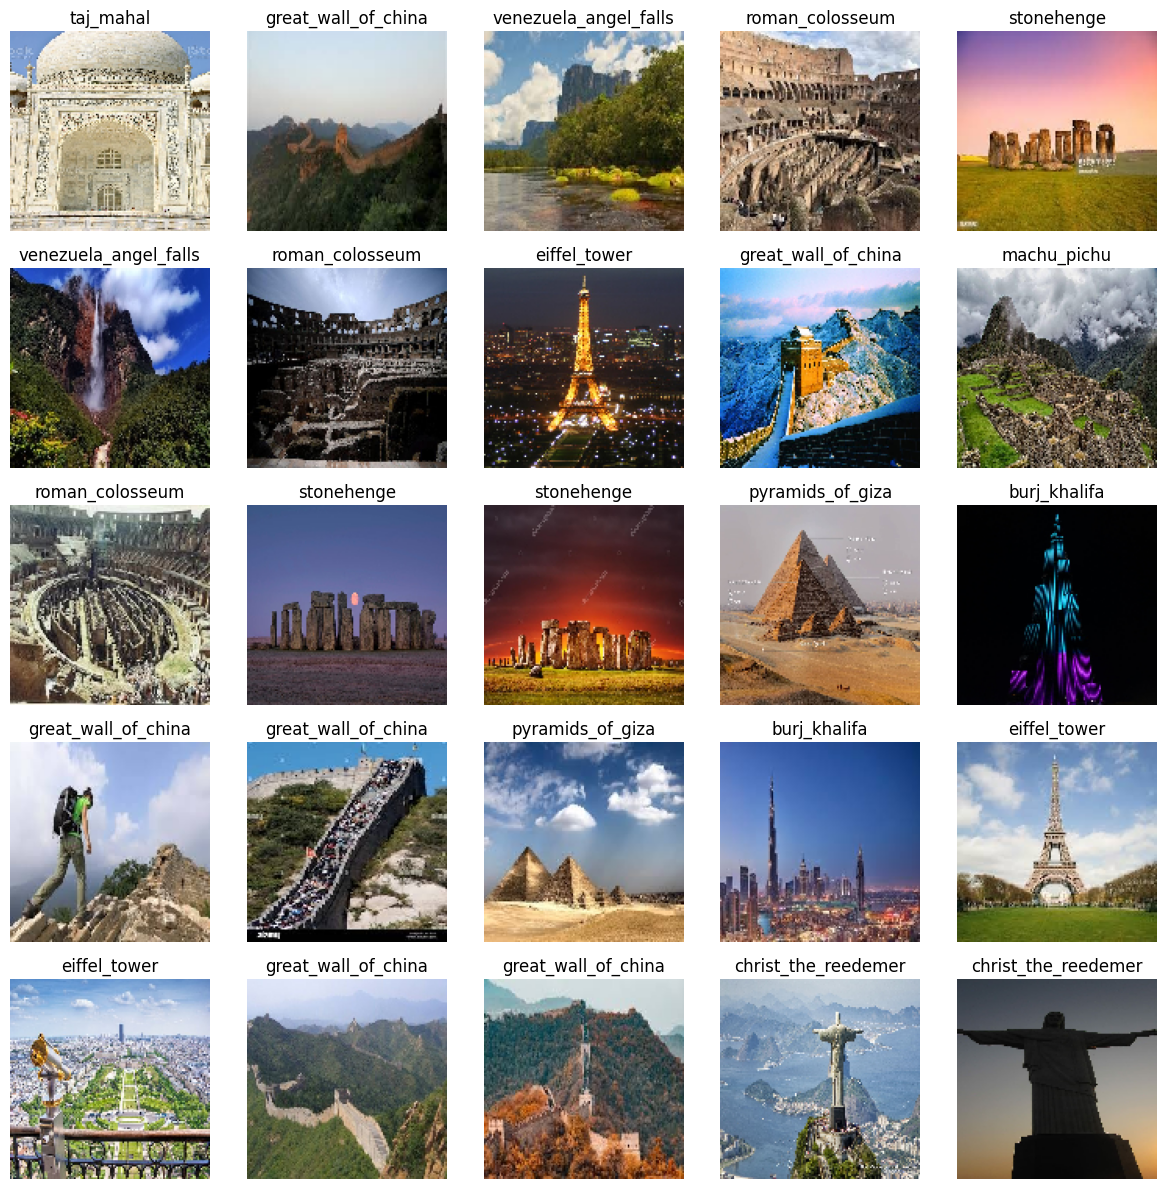

In [8]:

# Define number of rows and columns
rows, cols = 5, 5

# Create a figure
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Select 25 random indices
random_indices = np.random.choice(len(X), rows * cols, replace=False)

# Plot images with their labels
for i, idx in enumerate(random_indices):
    axes[i].imshow(X[idx].astype("uint8"))  # Convert to proper format
    axes[i].axis("off")
    axes[i].set_title(y[idx])  # Display label as title

plt.tight_layout()
plt.show()


In [9]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_onehot = to_categorical(y_encoded, num_classes=len(classes))

# define imagedatagenerator

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adadelta
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import AdamW


X_train, X_valid, y_train, y_valid = train_test_split(X, y_onehot, test_size=0.2, random_state=42)


# Define ImageDataGenerator for training (with augmentation) and validation (only rescaling)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=8)

# Create AlexNet Model

AlexNet was the 2012 ImageNet winner achieved a top-5 error of 15.3%, more than 10.8 percentage points lower than that of the runner up!

![](https://paperswithcode.com/media/methods/Screen_Shot_2020-06-22_at_6.35.45_PM.png)



In [12]:

model = Sequential()

# 1st Conv Layer 
model.add(Conv2D(96, (11, 11), input_shape=X_train.shape[1:],padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd Conv Layer 
model.add(Conv2D(256, (5, 5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd Conv Layer 
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(512, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 4th Conv Layer 
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

# 5th Conv Layer 
model.add(ZeroPadding2D((1, 1)))
model.add(Conv2D(1024, (3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 1st FC Layer
model.add(Flatten())
model.add(Dense(3072))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 2nd FC Layer
model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

# 3rd FC Layer
model.add(Dense(len(classes)))
model.add(BatchNormalization())
model.add(Activation('softmax'))


model.compile(loss = 'categorical_crossentropy',optimizer = AdamW(learning_rate=0.0001),metrics = ['accuracy'])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 128, 128, 96)        │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 128, 128, 96)        │             384 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 128, 128, 96)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 64, 64, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 64, 64, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 64, 64, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 34, 34, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 34, 34, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 34, 34, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_1 (ZeroPadding2D)     │ (None, 19, 19, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 1024)        │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 1024)        │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 19, 19, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d_2 (ZeroPadding2D)     │ (None, 21, 21, 1024)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 21, 21, 1024)        │       9,438,208 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 343,239,996 (1.28 GB)

 Trainable params: 343,219,812 (1.28 GB)

 Non-trainable params: 20,184 (78.84 KB)

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr=ReduceLROnPlateau(monitor="val_loss",factor=0.1,patience=3,min_lr=1e-6,verbose=1)
early_stopping=EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True,verbose=1)

history = model.fit(train_generator,epochs=50,validation_data=valid_generator,callbacks=[reduce_lr,early_stopping])

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


385/385 ━━━━━━━━━━━━━━━━━━━━ 69s 132ms/step - accuracy: 0.2464 - loss: 2.2423 - val_accuracy: 0.1078 - val_loss: 2.7350 - learning_rate: 1.0000e-04
Epoch 2/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.3638 - loss: 1.8774 - val_accuracy: 0.2740 - val_loss: 2.8569 - learning_rate: 1.0000e-04
Epoch 3/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - accuracy: 0.3835 - loss: 1.8323 - val_accuracy: 0.2260 - val_loss: 2.4376 - learning_rate: 1.0000e-04
Epoch 4/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - accuracy: 0.3997 - loss: 1.8024 - val_accuracy: 0.4792 - val_loss: 1.5493 - learning_rate: 1.0000e-04
Epoch 5/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - accuracy: 0.4018 - loss: 1.7487 - val_accuracy: 0.1896 - val_loss: 4.6514 - learning_rate: 1.0000e-04
Epoch 6/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 39s 100ms/step - accuracy: 0.4320 - loss: 1.7318 - val_accuracy: 0.5429 - val_loss: 1.3948 - learning_rate: 1.0000e-04
Epoch 7/50
385/385 ━━━━━━━━━━━━━━━━━━━━ 37s 95ms/step - acc

# Loss & Accuracy Graph

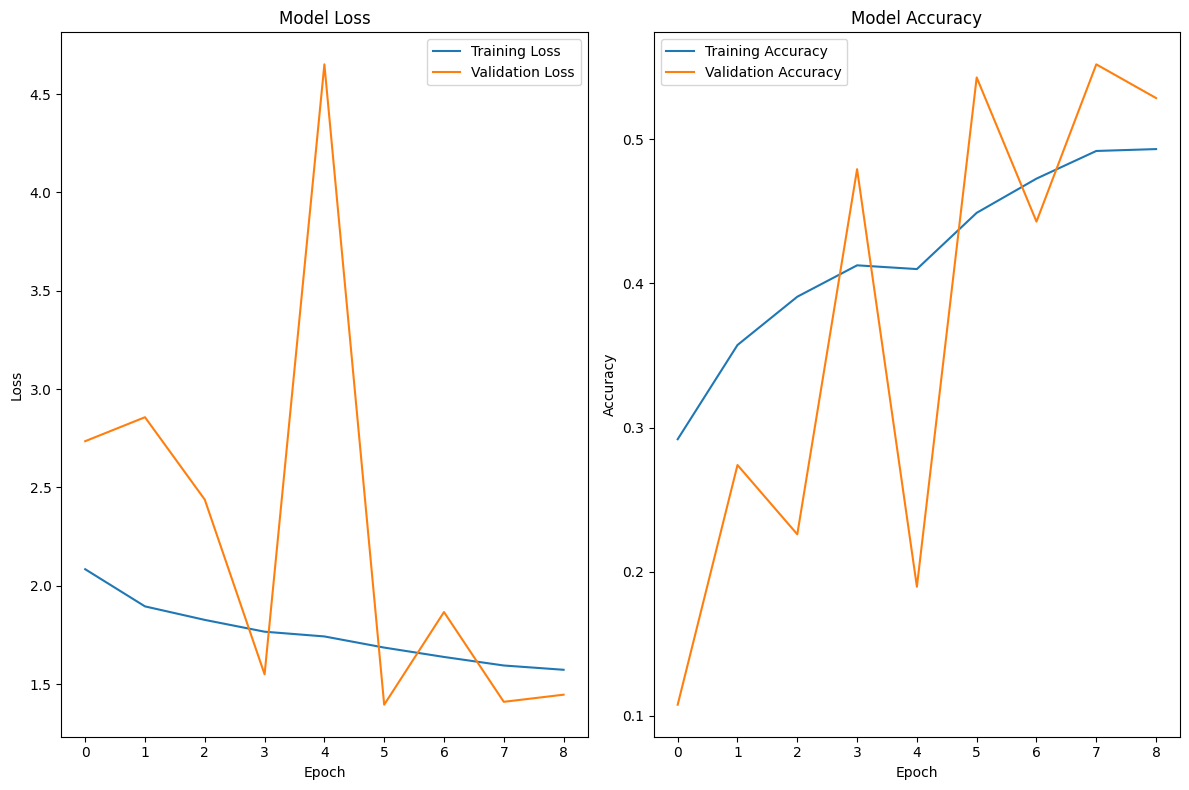

In [14]:
# Plotting Loss and Accuracy
plt.figure(figsize=(12, 8))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [15]:
result=model.evaluate(valid_generator)
print(f"Test Loss : {result[0]}")
print(f"Model Accuracy : {result[1]}")

97/97 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5672 - loss: 1.3632
Test Loss : 1.3948416709899902
Model Accuracy : 0.5428571701049805


# Confusion Matrix

97/97 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step


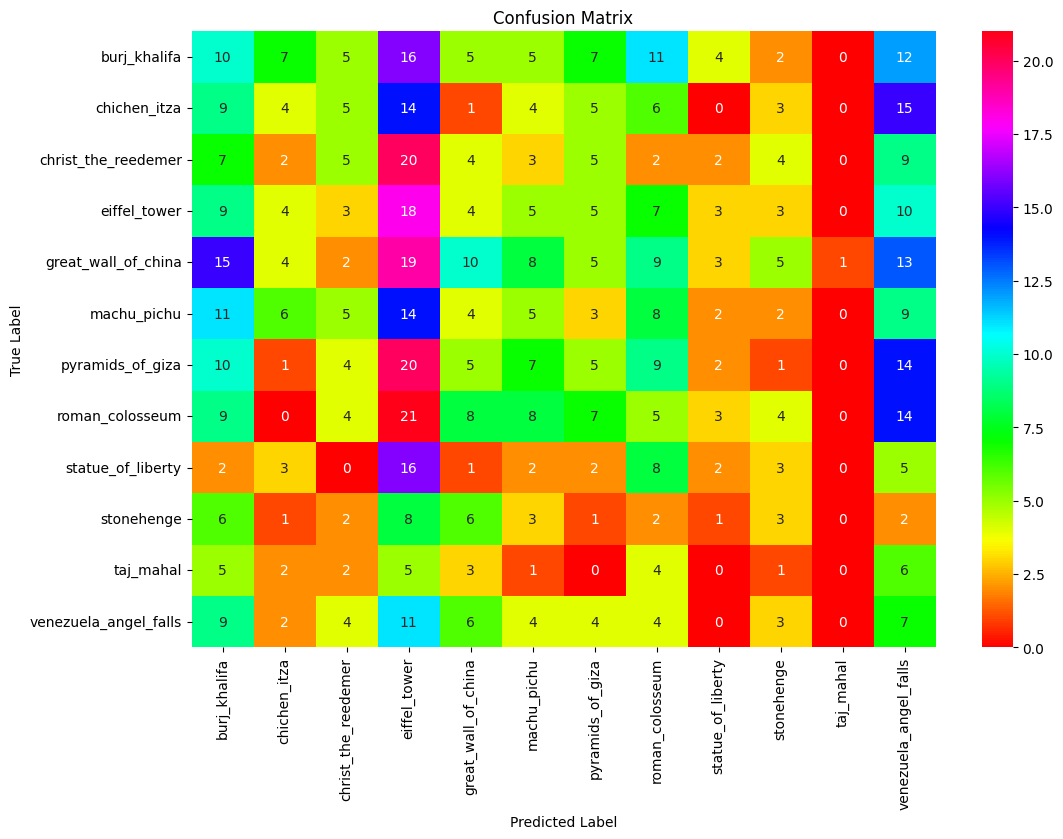

In [16]:

y_pred = model.predict(valid_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true=[]

for i in range(len(valid_generator)):
    _,labels=valid_generator[i]
    y_true.extend(np.argmax(labels,axis=1))

y_true=np.array(y_true)

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='hsv', xticklabels=label_name, yticklabels=label_name)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Classification Report

In [17]:
print(classification_report(y_true, y_pred_classes, target_names=label_name))

                       precision    recall  f1-score   support

         burj_khalifa       0.10      0.12      0.11        84
         chichen_itza       0.11      0.06      0.08        66
  christ_the_reedemer       0.12      0.08      0.10        63
         eiffel_tower       0.10      0.25      0.14        71
  great_wall_of_china       0.18      0.11      0.13        94
          machu_pichu       0.09      0.07      0.08        69
     pyramids_of_giza       0.10      0.06      0.08        78
      roman_colosseum       0.07      0.06      0.06        83
    statue_of_liberty       0.09      0.05      0.06        44
           stonehenge       0.09      0.09      0.09        35
            taj_mahal       0.00      0.00      0.00        29
venezuela_angel_falls       0.06      0.13      0.08        54

             accuracy                           0.10       770
            macro avg       0.09      0.09      0.08       770
         weighted avg       0.10      0.10      0.09 

# Roc Curve

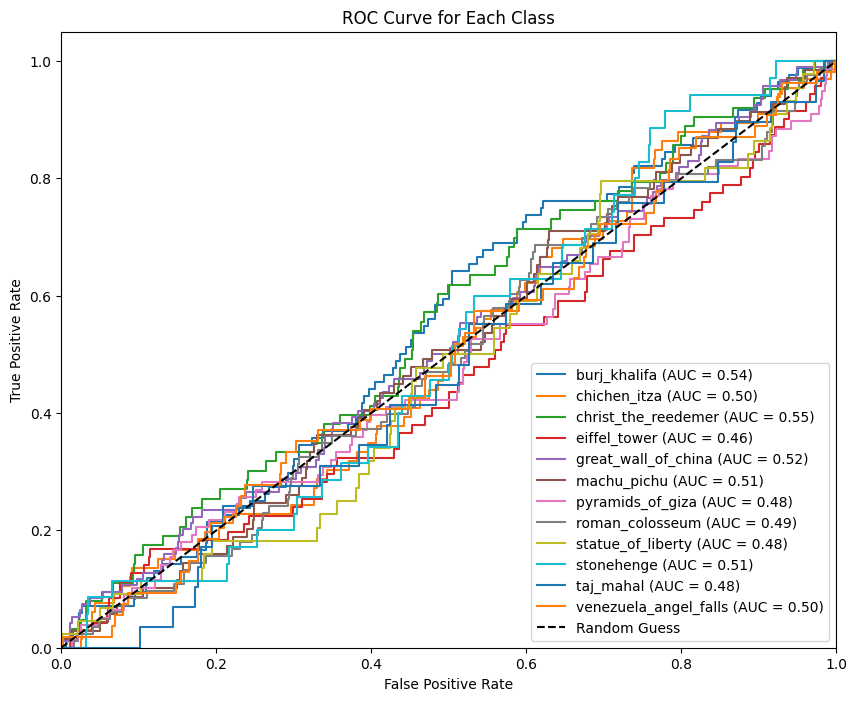

In [18]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Binarize the true labels (One-vs-All approach)
y_true_bin = label_binarize(y_true, classes=np.arange(len(label_name)))

# Compute ROC curve and AUC for each class
plt.figure(figsize=(10, 8))
for i, class_label in enumerate(label_name):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{class_label} (AUC = {roc_auc:.2f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')
plt.show()


# precision Recall Curve

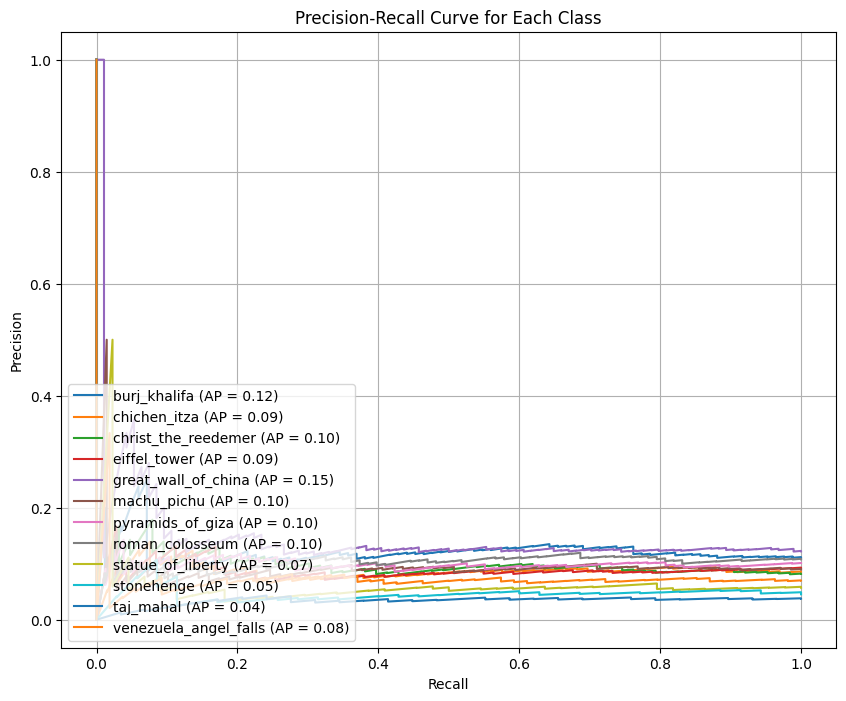

In [19]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute Precision-Recall curve and AUC for each class
plt.figure(figsize=(10, 8))

for i, class_label in enumerate(label_name):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    ap_score = average_precision_score(y_true_bin[:, i], y_pred[:, i])
    
    plt.plot(recall, precision, label=f'{class_label} (AP = {ap_score:.2f})')

# Plot formatting
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Each Class')
plt.legend(loc='lower left')
plt.grid()
plt.show()


# model prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 480ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


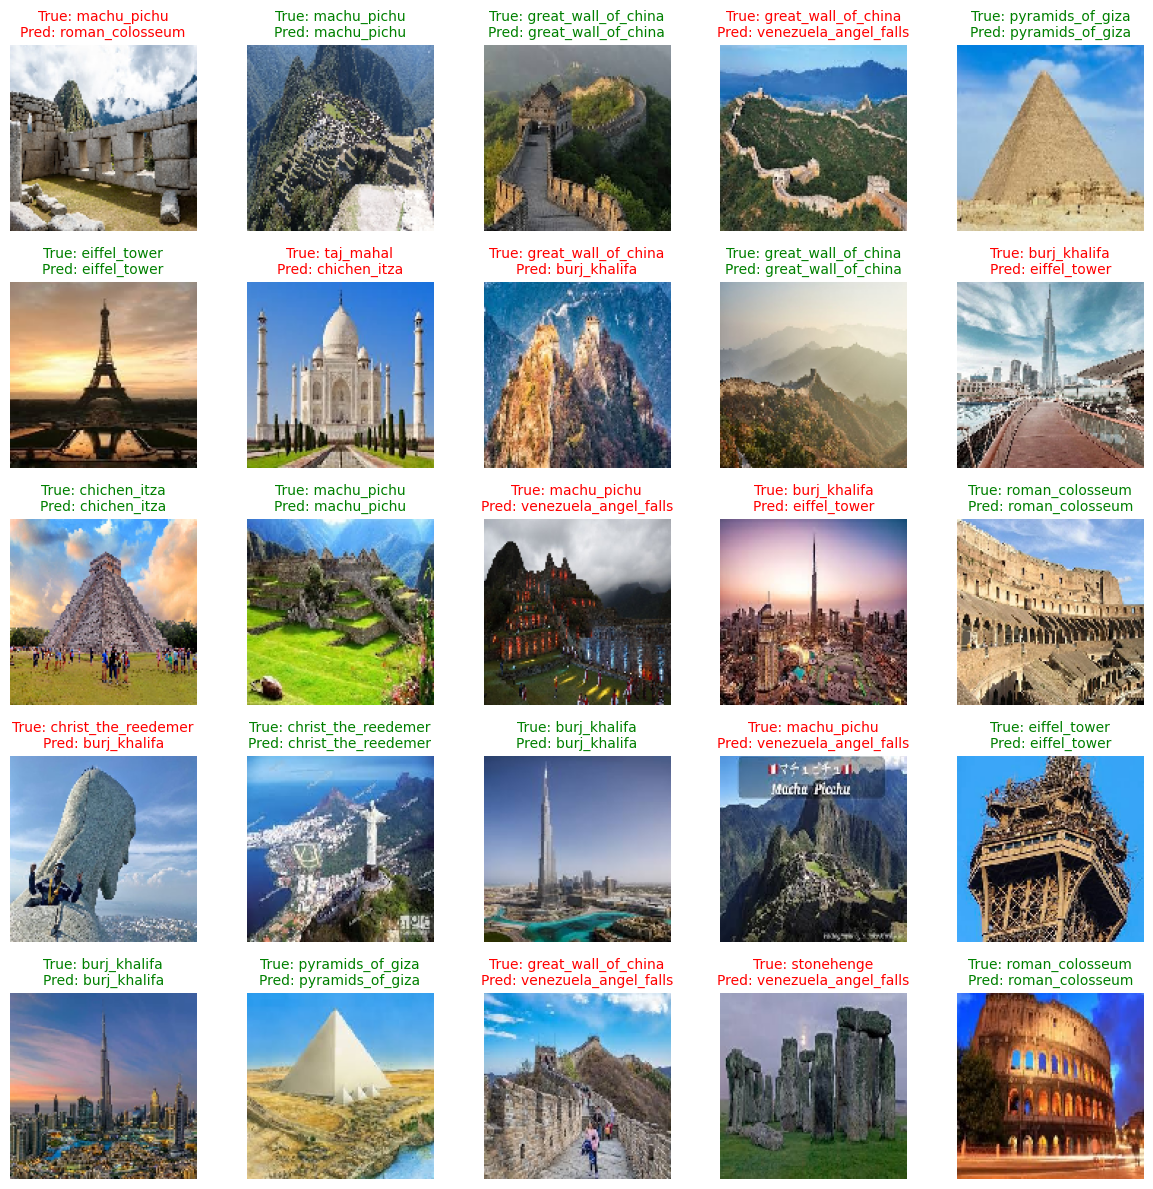

In [20]:


# Initialize lists to store images, true labels, and predicted labels
images = []
true_labels = []
pred_labels = []

# Collect 25 images from multiple batches if needed
while len(images) < 25:
    X_batch, y_batch = next(valid_generator)  # Get a batch
    y_true_batch = np.argmax(y_batch, axis=1)  # Convert one-hot labels to indices
    y_pred_batch = np.argmax(model.predict(X_batch), axis=1)  # Predict labels
    
    for i in range(len(X_batch)):
        if len(images) < 25:  # Stop once we have 25 images
            images.append(X_batch[i])
            true_labels.append(label_name[y_true_batch[i]])
            pred_labels.append(label_name[y_pred_batch[i]])
        else:
            break

# Plot 5x5 grid
fig, axes = plt.subplots(5, 5, figsize=(12, 12))

for i, ax in enumerate(axes.flat):
    img = images[i]
    true_label = true_labels[i]
    pred_label = pred_labels[i]

    # Title color based on correct/incorrect prediction
    color = 'green' if true_label == pred_label else 'red'

    ax.imshow(img)  # Show image
    ax.set_title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()


# Download Custom Image

In [21]:
import requests
from PIL import Image
from io import BytesIO

# Correct Image URL (make sure this is the direct URL to the image)
img_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQNREj-CbVvBMxBFLcDtLVOW443ivgY7ltqaw&s"

# Send a GET request to fetch the image
response = requests.get(img_url)

# Check if the request was successful
if response.status_code == 200:
    # Open the image from the response content
    img = Image.open(BytesIO(response.content))
    
    # Save the image to a file (change the path as needed)
    img.save('/kaggle/working/downloaded_image.jpg')
    print("Image saved successfully!")
else:
    print("Failed to download the image.")


Image saved successfully!


# Custom Data Prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


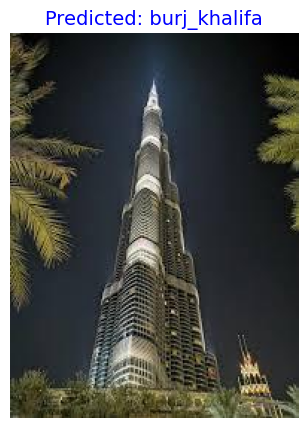

Prediction: burj_khalifa


In [22]:

def preprocess_image(img_path, target_size=(128, 128)):
    """Loads and preprocesses an image for prediction."""
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img) / 255.0  # Normalize
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_array

def predict_image(img_path, model, label_name):
    """Predicts the class of a given image and displays results."""
    img_array = preprocess_image(img_path)
    pred = model.predict(img_array)  # Get predictions
    pred_class = np.argmax(pred, axis=1)[0]  # Get class index
    pred_label = label_name[pred_class]  # Convert index to label

    # Display the image with the prediction
    plt.figure(figsize=(10, 5))
    img = image.load_img(img_path)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label}", fontsize=14, color='blue')
    plt.show()
    
    return pred_label

# Example usage:
img_path = "/kaggle/working/downloaded_image.jpg"  # Provide the path to your image
predicted_label = predict_image(img_path, model, label_name)
print(f"Prediction: {predicted_label}")
